In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [38]:
# import helper functions
import sys
import os

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
scripts_path = os.path.join(project_root, 'Src')

if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from plotting_utils import plot_metric_clusters
from clustering import align_labels, compute_kmeans_metrics

In [4]:
countries_data = pd.read_csv("../Data/Processed/worried_data_processed.csv")

In [5]:
X_PCA = np.load("../Data/Processed/X_PCA.npy")

# Clustering
The main objective of this project is to compare country groups obtained through unsupervised clustering based on Findex data to:
- World Bank classification by income (4 groups),
- Division into Frontier, Emerging, and Developed Markets (3 groups),
- The Economist Democracy Index (4 groups, 10 subgroups).

The World Bank divides countries into four groups, so the aim is to obtain four clusters. The Economist Democracy Index categorizes countries into four main groups based on scores ranging from 0 to 10. The first three groups each have two subgroups, and the last one has four subgroups. Therefore, the aim is not only to obtain four clusters but also to obtain 10 clusters. The division into Frontier, Emerging, and Developed Markets consists of three groups. Additionally, Emerging Markets are sometimes subdivided into various subgroups.

# K-means

In [51]:
N = 1
K_min = 3
K_max = 21
cluster_no = list(range(K_min, K_max))
param_grid = {
    'n_clusters': cluster_no,
}
wgss, silh_score, neg_silh_score = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

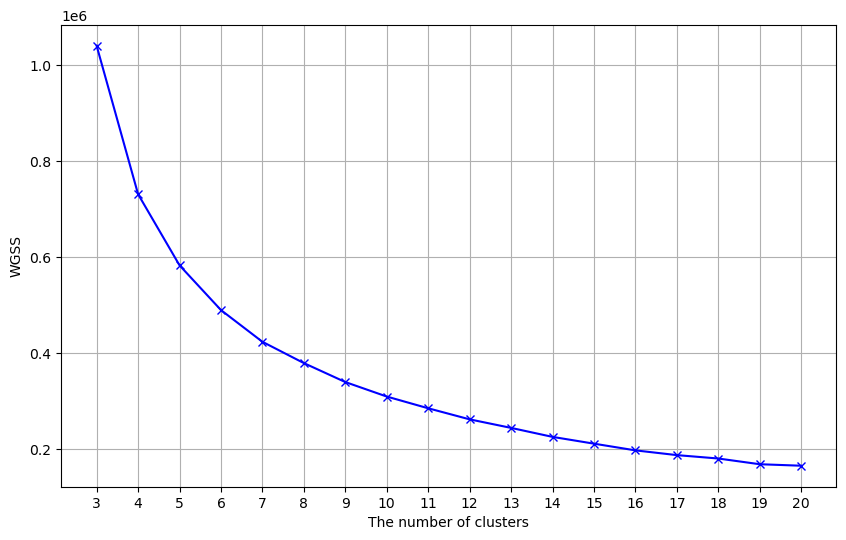

In [52]:
plt.figure(figsize = (10,6))
plt.plot(wgss.keys(), wgss.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("WGSS")
plt.grid(True)

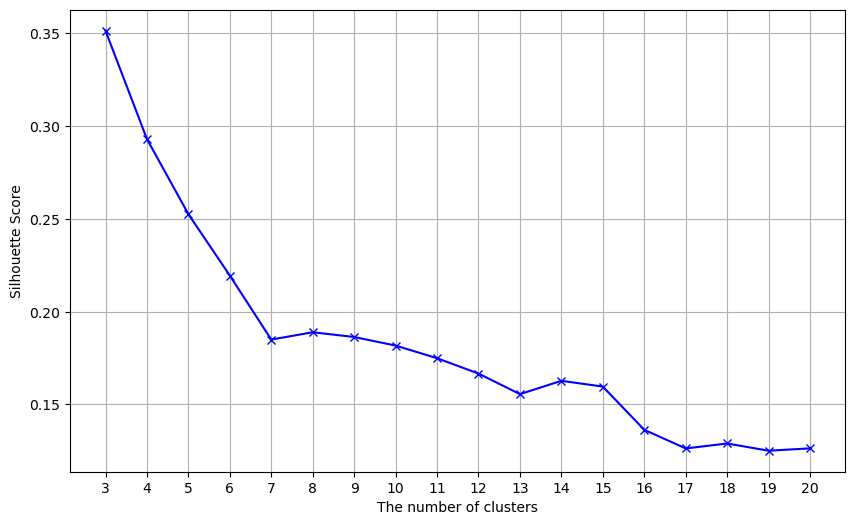

In [53]:
plt.figure(figsize = (10,6))
plt.plot(silh_score.keys(), silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

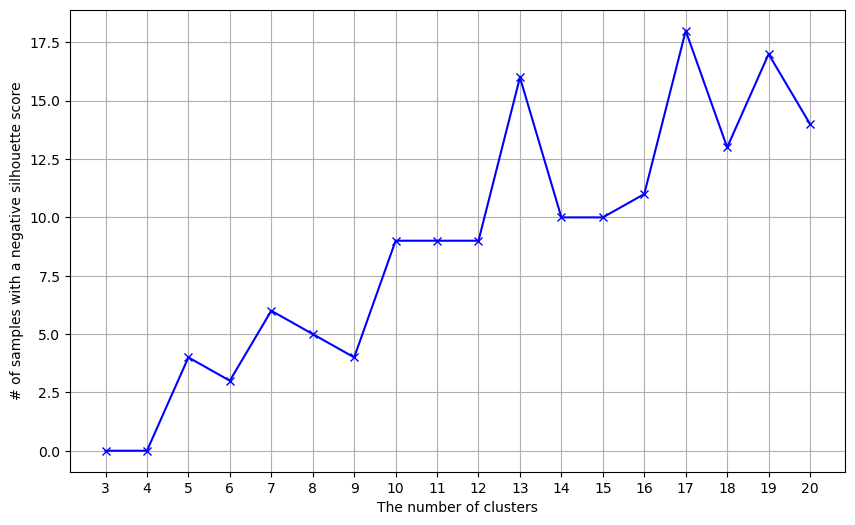

In [54]:
plt.figure(figsize = (10,6))
plt.plot(neg_silh_score.keys(), neg_silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("# of samples with a negative silhouette score")
plt.grid(True)

## Analysis of the Number of Clusters in K-means
Based on the WGSS, silhouette score, and the number of samples with a negative score, dividing the data into 3 or 4 clusters appears to be stable. The WGSS "elbow" occurs at 5 or 6 clusters, while dividing into 10 clusters results in relatively low WGSS, which may indicate unstable clustering.

The "elbow" of the silhouette score occurs around 7 clusters, further suggesting that 3 and 4 clusters provide stable clustering, whereas 10 clusters appear to be an unstable option.

Almost all samples have a positive silhouette score for 3 and 4 clusters, with fewer than 10 samples having a negative silhouette score for 10 clusters (less than 7% of samples).



## The Influence of K-means Parameters on the Robustness of Clusters
K-means clustering will be performed N = 50 times, and the label assignments for each country will be analyzed. The clustering is considered stable when each country is assigned the same label in almost every iteration.

There is no guarantee that the same cluster will retain the same label across different K-means iterations. To address this, label realignment is performed by solving the assignment problem, which involves maximizing the trace of the confusion matrix between the reference clustering and subsequent iterations. This ensures that the labels are consistently matched to the corresponding clusters across all runs.

In [56]:
N = 50
cluster_no = list(range(3, 11))
param_grid = {
    'n_clusters': cluster_no,
    'n_init': list(range(10, 111, 20)),
}
mean_wgss, mean_silh_score, mean_neg_silh_score = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

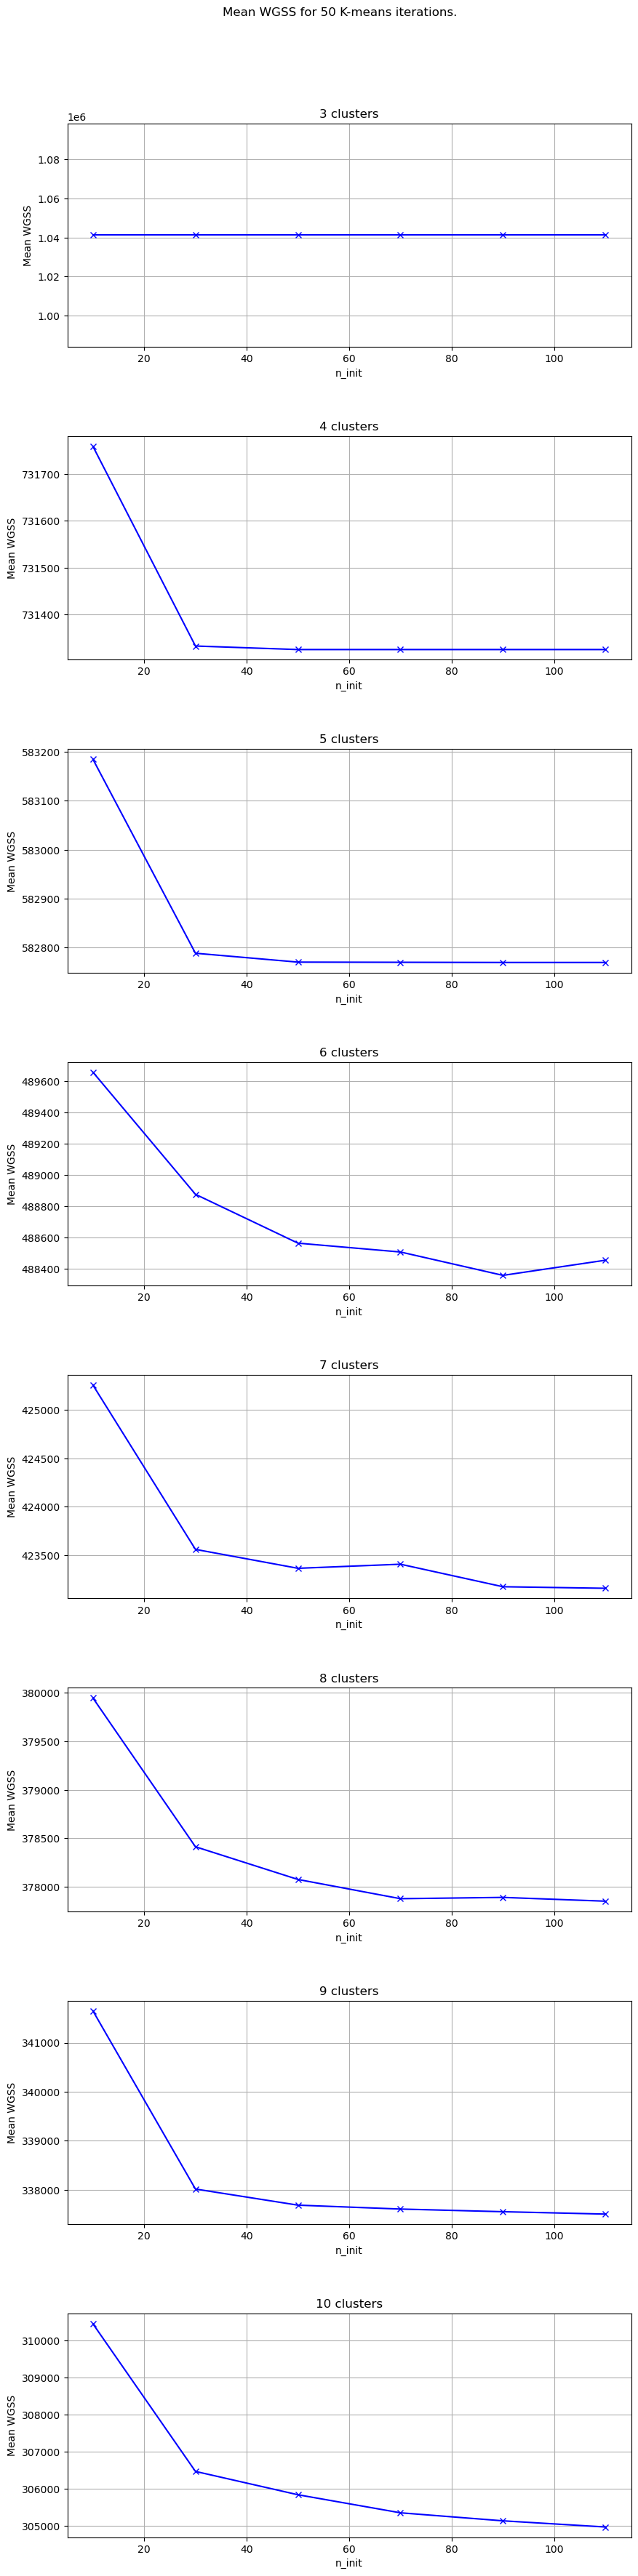

In [61]:
plot_title = " ".join(["Mean WGSS for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean WGSS"
plot_metric_clusters(cluster_no, mean_wgss, N, plot_title, xlabel, ylabel)

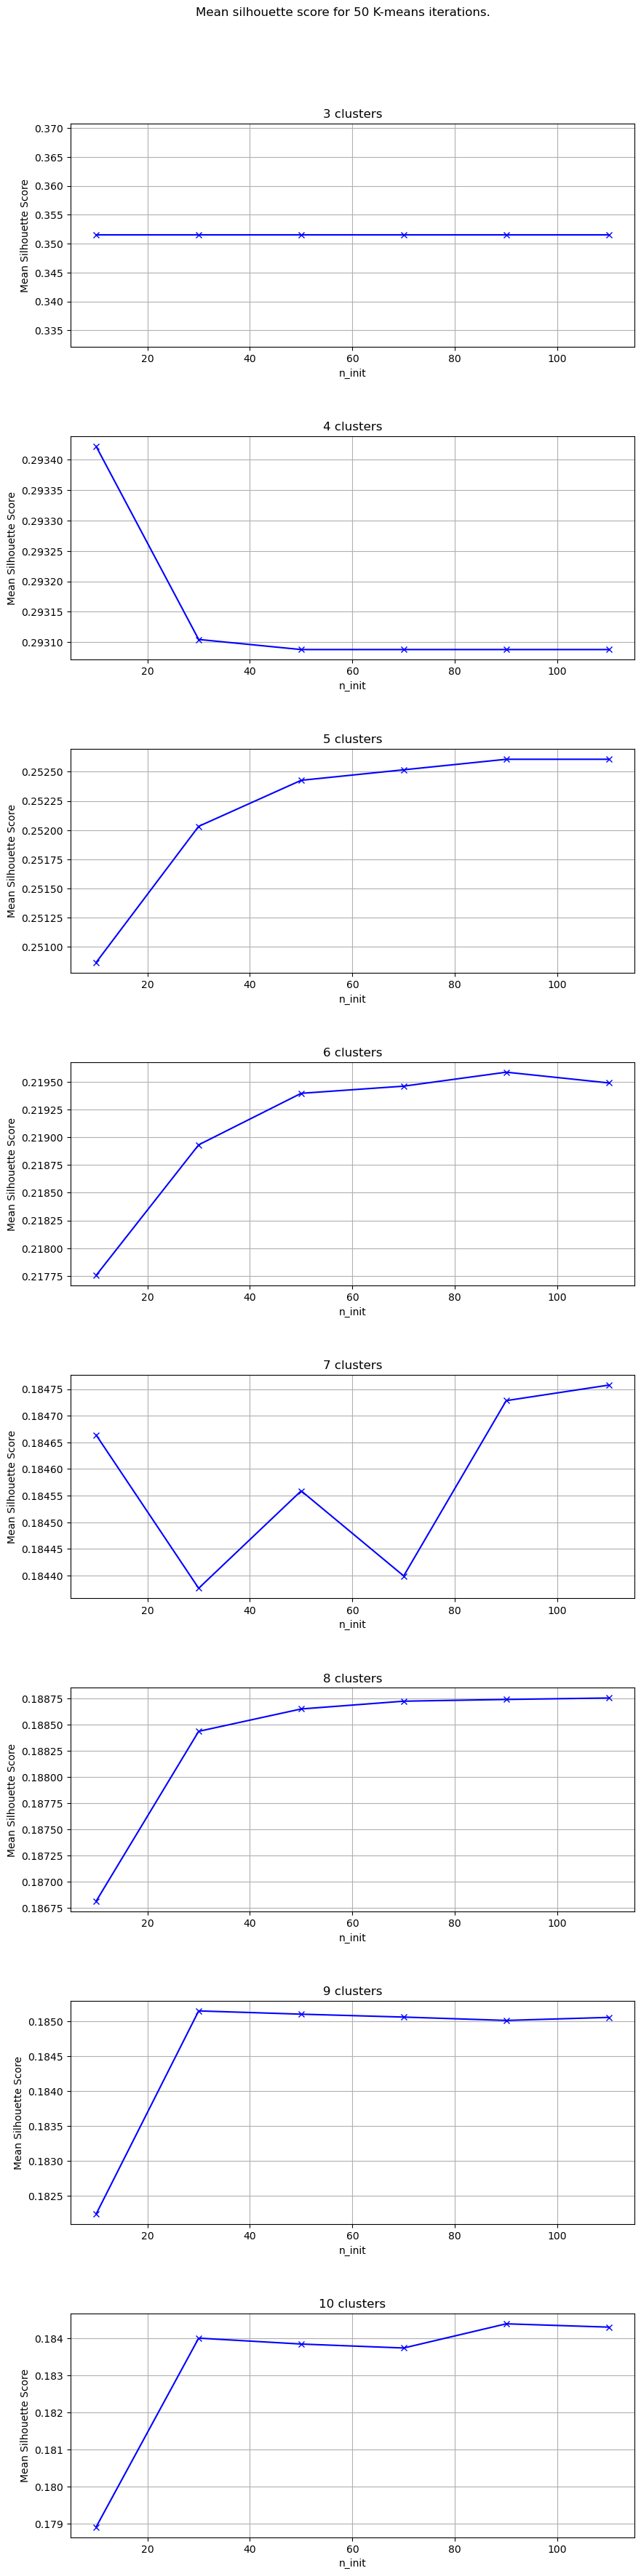

In [62]:
plot_title = " ".join(["Mean silhouette score for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean Silhouette Score"
plot_metric_clusters(cluster_no, mean_silh_score, N, plot_title, xlabel, ylabel)

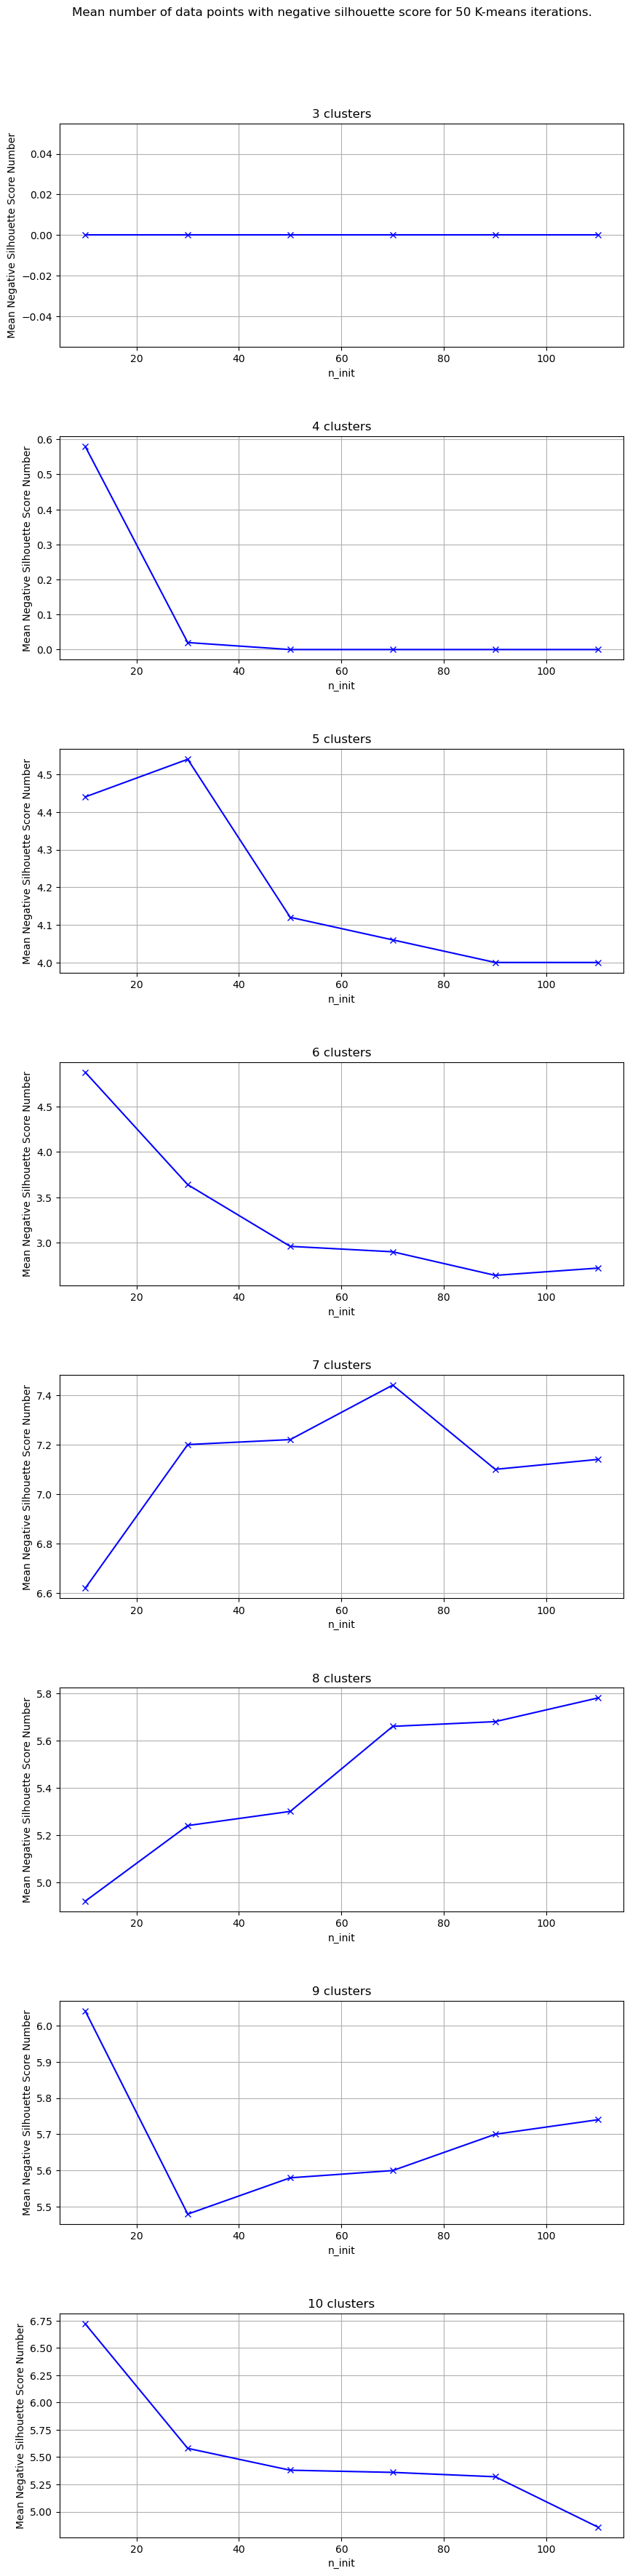

In [64]:
plot_title = " ".join(["Mean number of data points with negative silhouette score for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean Negative Silhouette Score Number"
plot_metric_clusters(cluster_no, mean_neg_silh_score, N, plot_title, xlabel, ylabel)

### Observations on the Influence of the n_init Parameter on the Robustness of Clustering
With an increasing number of random initializations, the solution quality—measured by WGSS and silhouette score—improves. For both WGSS and silhouette score, there appears to be an “elbow” at n_init = 30 for all cluster numbers greater than or equal to four.

The n_init parameter has no effect on clustering into three groups, which appears stable. As the number of clusters increases, there seem to be more local minima that K-means can get stuck in; however, with more random initializations, the algorithm is more likely to find optimal solutions.

In [40]:


N = 50

mean_wgss = {}
mean_silh_score = {}

for K in cluster_no:
    for pc in pc_no:
        labels = []
        iter_wgss = []
        iter_silh_score = []
        for n in range(N):
            # uses data after PCA with the no of principal components representing 90% of the explained variance
            kmeans = KMeans(n_clusters = K, n_init = 30).fit(X_PCA[:, 0:pc])
            labels.append(kmeans.labels_)
            iter_wgss.append(kmeans.inertia_)
            iter_silh_score.append(silhouette_score(X_PCA, kmeans.labels_))
        mean_wgss[K, pc] = np.mean(iter_wgss)
        mean_silh_score[K, pc] = np.mean(iter_silh_score)
        
    #aligned_labels = align_labels(labels)

    #print(K, "clusters:")
    #if np.all(aligned_labels == aligned_labels[0,:]):
    #    print("All elements are clustered the same")
    #else:
    #    print("There are differences in clustering")

In [80]:
N = 50
cluster_no = [3, 4, 10]
pc_no = [1, 3, 7, 22]
param_grid = {
    'n_clusters': cluster_no,
    'pca_components': pc_no
}
mean_wgss, mean_silh_score, mean_neg_silh_score = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

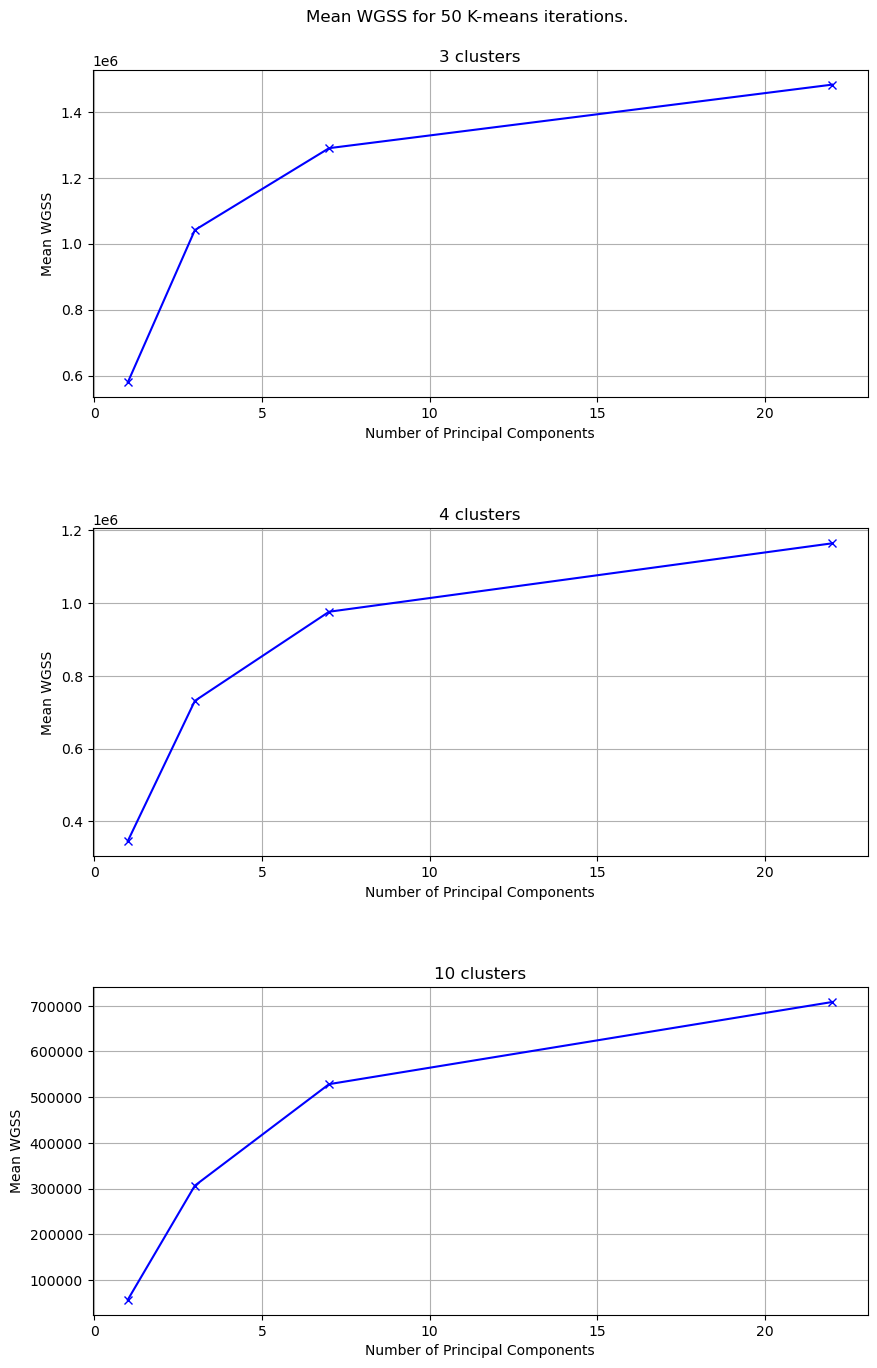

In [82]:
plot_title = " ".join(["Mean WGSS for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean WGSS"
plot_metric_clusters(cluster_no, mean_wgss, N, plot_title, xlabel, ylabel)

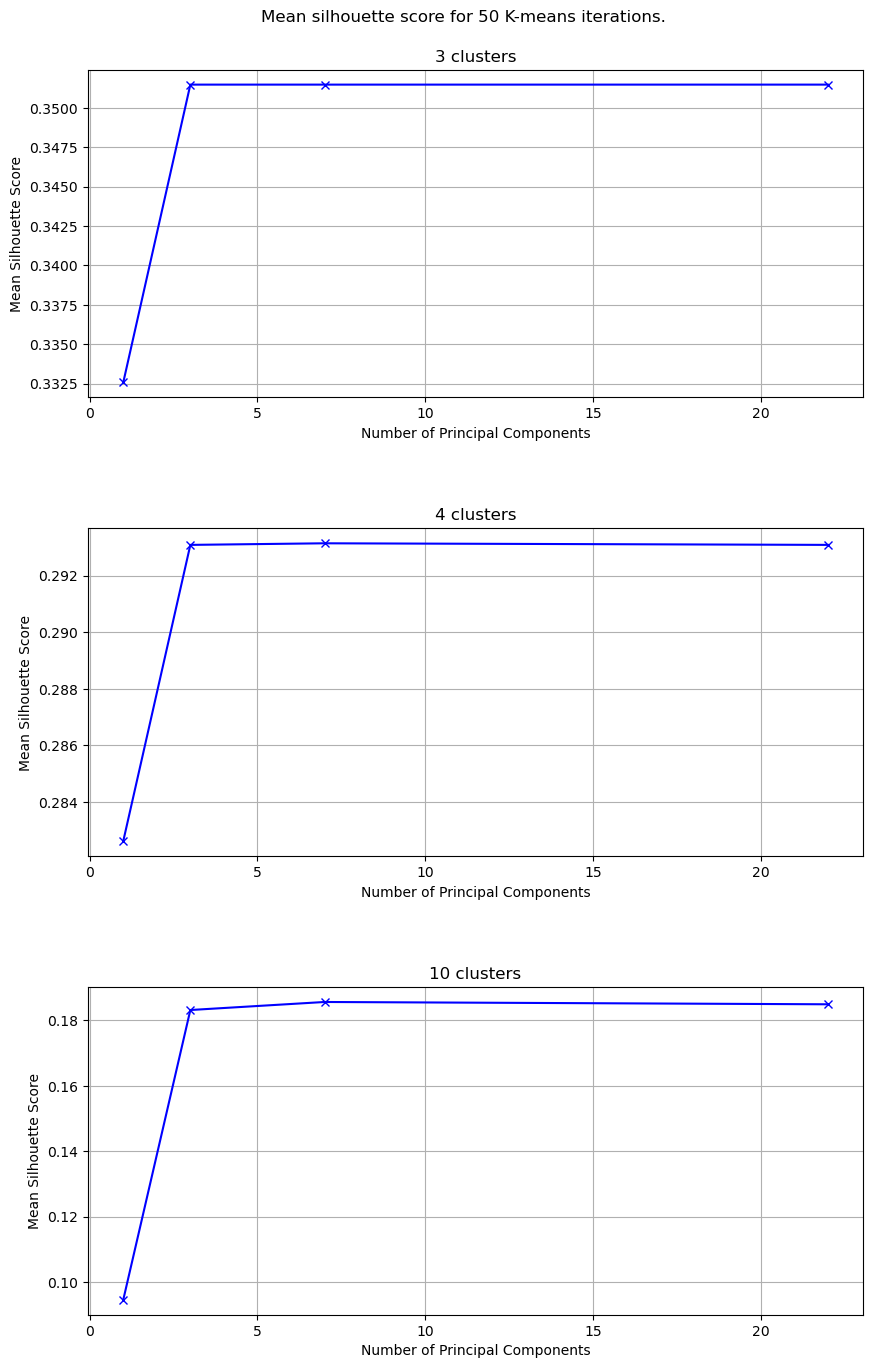

In [83]:
plot_title = " ".join(["Mean silhouette score for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean Silhouette Score"
plot_metric_clusters(cluster_no, mean_silh_score, N, plot_title, xlabel, ylabel)

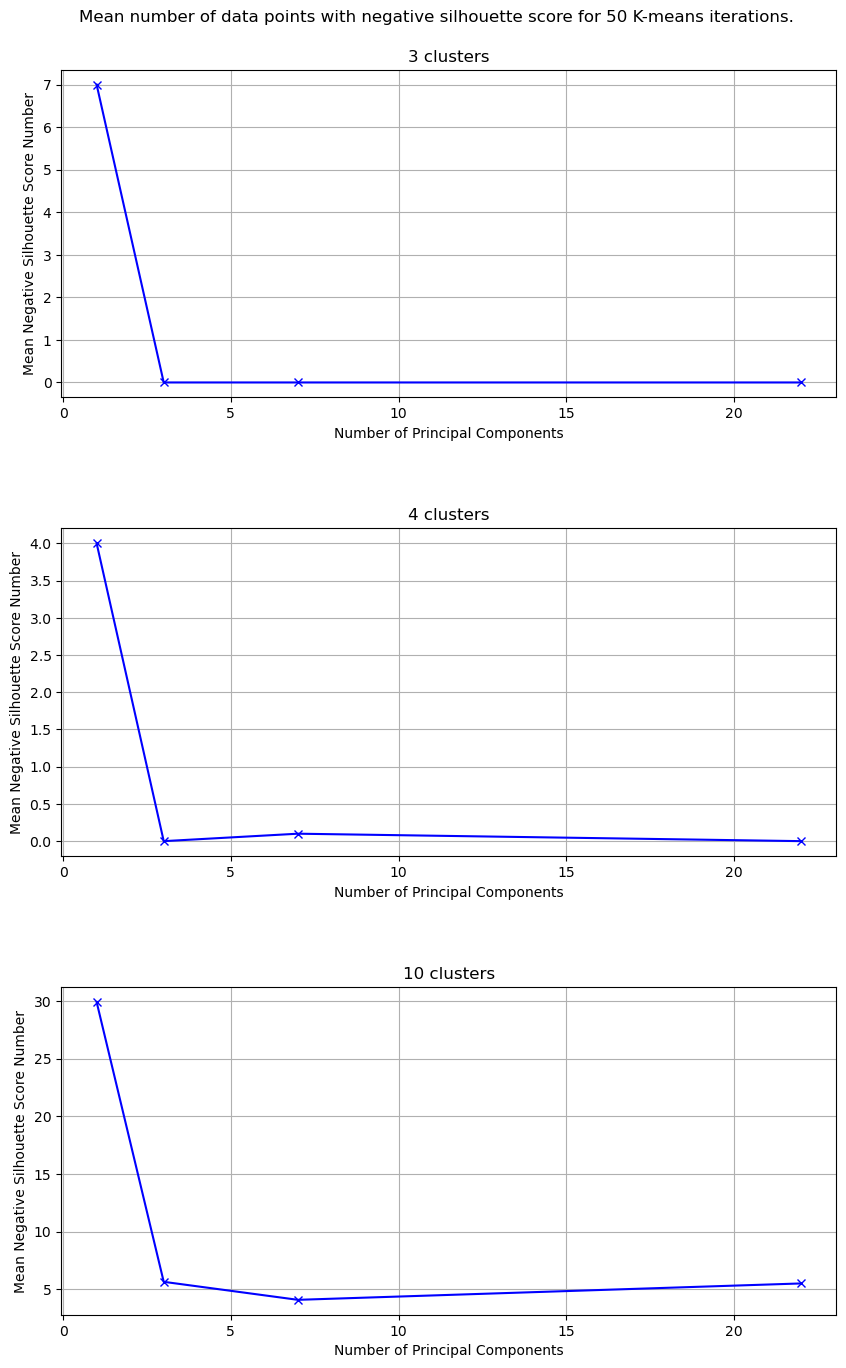

In [84]:
plot_title = " ".join(["Mean number of data points with negative silhouette score for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean Negative Silhouette Score Number"
plot_metric_clusters(cluster_no, mean_neg_silh_score, N, plot_title, xlabel, ylabel)

### Observations on the Influence of the Number of Principal Components on the Robustness of Clustering
It appears that as the number of principal components increases, the quality of clustering—measured by the within-group sum of squares (WGSS)—declines. This outcome is consistent with the K-means algorithm’s susceptibility to noise or redundant features, which add little discriminatory information.

In this dataset, after principal component analysis (PCA):
- The first principal component accounts for over 75% of the variance.
- Three principal components explain over 90% of the variance.
- Twenty two principal components together explain over 99% of the variance.

The main structure of the dataset is captured by the first three principal components. The subsequent components explain only a small fraction of the variance, diluting the clear separation in the data. It is important to feed the clustering algorithm principal components with high variance, as these are more informative.

In contrast, the silhouette score improves when more of the total variance is included in the principal components. It reaches an “elbow” at three principal components (capturing over 90% of the variance) and does not show a significant improvement with additional components. Adding more principal components beyond this point increases complexity and introduces noise, thus raising WGSS without further boosting the silhouette score.